In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from lazypredict.Supervised import LazyClassifier
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import NuSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import joblib  # Para guardar los modelos
from lightning import seed_everything

from utils import SEED

# SET RANDOM SEED
seed_everything(SEED)

Seed set to 3407


3407

In [2]:
def read_pickle(filename: str) -> pd.DataFrame:
    with open(filename, 'rb') as f:
        return pd.DataFrame(pickle.load(f))

In [4]:
dataset_train_path = "data/03-combined/spanish_paragraphs_clustering/clustring_embedding_train.pkl"
dataset_test_path = "data/03-combined/spanish_paragraphs_clustering/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

In [5]:

tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(dataset_train["sample"])-1), n_iter=1000)

X_2d = tsne.fit_transform(np.array(dataset_train["sample"].to_list()))

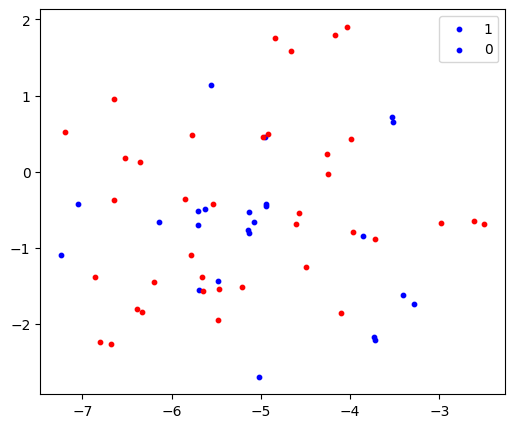

In [6]:
# represent the data in a scatter plot the are only 2 clusters the colors must be red for 0 and blue for 1
colors = ['red', 'blue']
plt.figure(figsize=(6, 5))
for i in range(len(X_2d)):
    plt.scatter(X_2d[i, 0], X_2d[i, 1], color=colors[dataset_train['label'][i]], s=10)
# add legend
plt.legend(['1', '0'], loc='upper right')
plt.show()

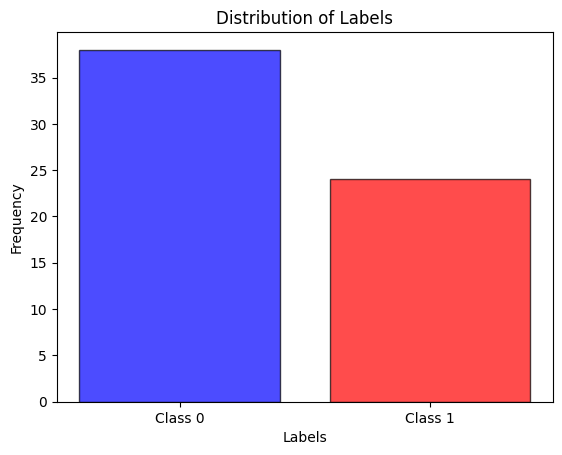

In [7]:
# Count the occurrences of each label
label_counts = dataset_train['label'].value_counts()

# Plot the histogram manually to assign colors per label
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'], alpha=0.7, edgecolor='black')

# Adding labels, legend, and title
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['Class 0', 'Class 1'])
#plt.legend(['Class 0', 'Class 1'], loc="upper right")

# Show the plot
plt.show()

## CLF

In [8]:
X_train = np.array(dataset_train["sample"].to_list())
# get subset of the data using shuffle
X_train = X_train[:1000]
y_train = np.array(dataset_train["label"].to_list())
y_train = y_train[:1000]
X_test = np.array(dataset_test["sample"].to_list())
y_test = np.array(dataset_test["label"].to_list())

In [9]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:04<00:00,  7.70it/s]

[LightGBM] [Info] Number of positive: 24, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17163
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387097 -> initscore=-0.459532
[LightGBM] [Info] Start training from score -0.459532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [10]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.80               0.86     0.86      0.81   
NearestCentroid                    0.80               0.86     0.86      0.81   
LogisticRegression                 0.70               0.79     0.79      0.71   
SGDClassifier                      0.70               0.79     0.79      0.71   
Perceptron                         0.70               0.79     0.79      0.71   
BernoulliNB                        0.80               0.76     0.76      0.80   
ExtraTreesClassifier               0.80               0.76     0.76      0.80   
NuSVC                              0.80               0.76     0.76      0.80   
XGBClassifier                      0.70               0.69     0.69      0.71   
GaussianNB                         0.70               0.69     0.69      0.71   
SVC                         

In [11]:
print(predictions)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.80               0.86     0.86      0.81   
NearestCentroid                    0.80               0.86     0.86      0.81   
LogisticRegression                 0.70               0.79     0.79      0.71   
SGDClassifier                      0.70               0.79     0.79      0.71   
Perceptron                         0.70               0.79     0.79      0.71   
BernoulliNB                        0.80               0.76     0.76      0.80   
ExtraTreesClassifier               0.80               0.76     0.76      0.80   
NuSVC                              0.80               0.76     0.76      0.80   
XGBClassifier                      0.70               0.69     0.69      0.71   
GaussianNB                         0.70               0.69     0.69      0.71   
SVC                         

# Optimzed clf

In [12]:
X_train = np.array(dataset_train["sample"].to_list())
y_train = np.array(dataset_train["label"].to_list())
X_test = np.array(dataset_test["sample"].to_list())
y_test = np.array(dataset_test["label"].to_list())

In [13]:


# Definición de modelos y sus respectivos hiperparámetros
models = {
    "RandomForest": (RandomForestClassifier(n_jobs=-1), {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }),
}

# Diccionario para guardar los mejores modelos
best_models = {}

# Optimización y evaluación
for model_name, (model, param_grid) in models.items():
    print(f"\nOptimizing {model_name}...")
    grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Mejores hiperparámetros
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Evaluación en conjunto de prueba
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
    
    # Guardar el mejor modelo en el diccionario
    best_models[model_name] = best_model


Optimizing RandomForest...
Best parameters for RandomForest: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}
Classification report for RandomForest:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.50      0.33      0.40         3

    accuracy                           0.70        10
   macro avg       0.62      0.60      0.60        10
weighted avg       0.68      0.70      0.68        10



In [14]:
import os

model_to_save = "RandomForest"  # Cambiar por "SVC" o "GaussianNB" si se prefiere otro
FOLDER = "models"
os.makedirs(FOLDER, exist_ok=True)
if model_to_save in best_models:
    file = os.path.join(FOLDER, f"{model_to_save}_best_model.pkl")
    joblib.dump(best_models[model_to_save], file)
    print(f"Modelo {model_to_save} guardado como {model_to_save}_best_model.pkl")
else:
    print(f"No se encontró el modelo {model_to_save} en el diccionario.")


Modelo RandomForest guardado como RandomForest_best_model.pkl


In [53]:
# load the model
loaded_model = joblib.load(file)
print(loaded_model)

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200, n_jobs=-1)
